In [1]:
#Importamos todas las librerias a utilizar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import plotly
import plotly.express as px
from matplotlib import style
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression


In [2]:
# Funcion para calcular la distancia entre dos puntos a través de la función haversine,
# esto nos permite convertir coordenadas en unidades de distancia
from math import radians, cos, sin, asin, sqrt
def DistanciaGPS (lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convertimos grados decimales en radianes
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # Se utiliza la formula Haversine
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

# Importamos el dataset de prueba (una versión de solo un mes para poder definir los procesos de limpiezas de data
from google.colab import drive 
drive.mount('/content/gdrive')

import pandas as pd 
df=pd.ExcelFile('TFM DATABASE.xlsx')


In [3]:
df=pd.ExcelFile('TFM DATABASE.xlsx')
df1 = pd.read_excel(df,'GPS - Enero 2020', na_values='?')
df1.head()

,Fec. Prod,Doc. Transporte,WERKS,FECHA_DESP,KUNNR,IDEOBRA,MATNR,FORMULA,ID_ESTRUC,ID_MODALIDAD,...,T.Proceso,T.Traslado,T.Espera,T.Descarga,T.Retorno,TTOTAL,Dia,Fecha_DiaSem,FinSemana,FinMes
0,2020-01-02 07:13:00,1826870,1209,02.01.2020,50007386,9000031161,004-01606,C210-MS-H57-A4,15,1,...,NaN,NaN,NaN,NaN,NaN,NaN,jueves,5,0,0
1,2020-01-02 10:47:00,1826962,1209,02.01.2020,50100921,9000042078,004-02808,M1:5-I-A5,18,2,...,21.0,14.0,NaN,NaN,93.0,128.0,jueves,5,0,0
2,2020-01-02 11:02:00,1826968,1219,02.01.2020,39760908,9000042681,004-01767,C175-I-H57-A5,20,1,...,24.0,1222.0,NaN,NaN,26.0,1272.0,jueves,5,0,0
3,2020-01-02 11:07:00,1826969,1213,02.01.2020,11402283,9000042938,004-01624,C210-MS-H67-A5,11,2,...,NaN,21.0,25.0,17.0,18.0,81.0,jueves,5,0,0
4,2020-01-02 11:22:00,1826979,1217,02.01.2020,39760908,9000041680,004-01624,C210-MS-H67-A5,10,2,...,NaN,17.0,22.0,3.0,17.0,59.0,jueves,5,0,0


In [4]:
# Podemos observar la cantidad de valores nulos que se encuentran en la data
df1.isnull().sum()
    

Fec. Prod                            0
Doc. Transporte                      0
WERKS                                0
FECHA_DESP                           0
KUNNR                                0
IDEOBRA                              0
MATNR                                0
FORMULA                              0
ID_ESTRUC                            0
ID_MODALIDAD                         0
VBELN_PED                            0
VBELN_ENTREGA                        0
WERK LON                             0
WERK LAT                             0
OBRA LAT                             2
OBRA LON                             2
DES_ESTRUCTURA                     116
Estado                             167
Placa                                0
Cliente                              0
Descripción de Obra                  0
Pto. Exped                           0
V. Entregado                         0
H. Program                           0
Tiempo de Proceso 1               1234
Tiempo de Proceso 2      

In [6]:
#Funcion Dummy
# Definimos la función que nos ayudara a crear los dummies para alimentar el modelo
#Data Transformation With Functions 1)Dummy para Plant 2)Dummy Para Estrutura 3)Dummy para modalidad 4)Aplicar Funcion de Distancia 5)Dummy para el dia de la semana

def dummy_convert (df,ID_ESTRUC):

    estruturas = pd.get_dummies(df[ID_ESTRUC], prefix = ID_ESTRUC)
    df = pd.concat([df, estruturas], axis = 1)

    return df




In [7]:
# Obtenemos un analisis de la estadística de la data con los dummies creados
# df1 = pd.read_excel(df,'GPS - Enero 2020')
df1.describe()

,Doc. Transporte,WERKS,KUNNR,IDEOBRA,ID_ESTRUC,ID_MODALIDAD,VBELN_PED,VBELN_ENTREGA,WERK LON,WERK LAT,...,V. Entregado,T.Proceso,T.Traslado,T.Espera,T.Descarga,T.Retorno,TTOTAL,Fecha_DiaSem,FinSemana,FinMes
count,5.865000e+03,5865.000000,5.865000e+03,5.865000e+03,5865.000000,5865.000000,5.865000e+03,5.865000e+03,5865.000000,5865.000000,...,5865.000000,4424.000000,5170.000000,4077.000000,4213.000000,5184.000000,5864.000000,5865.000000,5865.000000,5865.000000
mean,1.835786e+06,1418.126343,3.346716e+08,9.000038e+09,14.260870,2.855925,2.004224e+08,2.001395e+09,-6.674300,-79.665294,...,6.887758,27.767857,41.785300,22.105224,45.662473,41.060185,142.262960,4.630009,0.158227,0.044331
std,5.189307e+03,875.928047,6.621355e+08,5.748341e+03,9.891696,4.401206,2.535832e+03,3.381704e+03,1.440436,1.178087,...,1.539636,45.588712,102.354334,25.438499,41.515441,57.006668,140.120312,1.655488,0.364985,0.205847
min,1.826870e+06,1203.000000,1.001540e+07,9.000002e+09,1.000000,1.000000,2.003542e+08,2.001389e+09,-9.103467,-81.274960,...,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,1.831157e+06,1203.000000,2.537579e+07,9.000034e+09,8.000000,1.000000,2.004214e+08,2.001392e+09,-8.138488,-80.718861,...,6.000000,18.000000,11.000000,5.000000,19.000000,11.000000,77.000000,3.000000,0.000000,0.000000
50%,1.835803e+06,1213.000000,5.000710e+07,9.000039e+09,11.000000,2.000000,2.004225e+08,2.001395e+09,-6.779977,-79.880310,...,8.000000,23.000000,24.000000,13.000000,34.000000,24.000000,124.000000,5.000000,0.000000,0.000000
75%,1.840167e+06,1219.000000,5.010092e+07,9.000042e+09,16.000000,2.000000,2.004235e+08,2.001398e+09,-5.164840,-79.010054,...,8.000000,29.000000,42.000000,28.000000,59.000000,49.000000,180.000000,6.000000,0.000000,0.000000
max,1.844886e+06,5212.000000,1.900002e+09,9.000044e+09,50.000000,21.000000,2.004248e+08,2.001401e+09,-4.599295,-76.339073,...,9.500000,1319.000000,1428.000000,192.000000,1119.000000,1369.000000,2083.000000,7.000000,1.000000,1.000000


In [8]:
# Es necesario estandarizar el formato de las columnas y eliminar los espacios para trabajar de manera mas fluida
df1.columns

Index(['Fec. Prod', 'Doc. Transporte', 'WERKS', 'FECHA_DESP', 'KUNNR     ',
       'IDEOBRA   ', 'MATNR    ', 'FORMULA                       ',
       'ID_ESTRUC', 'ID_MODALIDAD', 'VBELN_PED', 'VBELN_ENTREGA', 'WERK LON',
       'WERK LAT', 'OBRA LAT', 'OBRA LON', 'DES_ESTRUCTURA', 'Estado', 'Placa',
       'Cliente', 'Descripción de Obra', 'Pto. Exped', 'V. Entregado',
       'H. Program', 'Tiempo de Proceso 1', 'Tiempo de Proceso 2',
       'Tiempo Proceso', 'Traslado a Obra 1', 'Traslado a Obra 2',
       'Tiempo Translado Minutos', 'Espera en Obra 1', 'Espera en Obra 2',
       'Tiempo Espera Minutos', 'Descarga en Obra 1', 'Descarga en Obra 2',
       'Tiempo Descarga Minutos', 'Retorno as Planta 1', 'Retorno as Planta 2',
       'Tiempo Retorno Planta Minutos', 'Dif. Total', 'Reconstruido',
       'T.Proceso', 'T.Traslado', 'T.Espera', 'T.Descarga', 'T.Retorno',
       'TTOTAL', 'Dia', 'Fecha_DiaSem', 'FinSemana', 'FinMes'],
      dtype='object')

In [9]:
# procedemos a crear un diccionario con los nuevos valores de columnas
df1.rename(columns={'Fec. Prod' : 'FEC_PROD',
                'Doc. Transporte' : 'DOC_TRANS',
                    'WERKS' : 'WERKS',
                    'FECHA_DESP' : 'FECHA_DESP',
                    'KUNNR     ' : 'KUNNR',
                    'IDEOBRA   ' : 'IDEOBRA',
                    'MATNR    ' : 'MATNR',
                    'FORMULA                       ' : 'FORMULA',
                    'ID_ESTRUC' : 'ID_ESTRUC',
                    'ID_MODALIDAD' : 'ID_MODALIDAD',
                    'VBELN_PED' : 'VBELN_PED',
                    'VBELN_ENTREGA' : 'VBELN_ENTREGA',
                    'WERK LON' : 'WERK_LON',
                    'WERK LAT' : 'WERK_LAT' ,
                    'OBRA LAT': 'OBRA_LAT',
                    'OBRA LON' : 'OBRA_LON',
                    'DES_ESTRUCTURA' : 'DES_ESTRUCTURA',
                    'Estado': 'ESTADO',
                    'Placa': 'PLACA',
                    'Cliente': 'CLIENTE',
                    'Descripción de Obra': 'DESC_OBRA',
                    'Pto. Exped': 'PTO_EXPED',
                    'V. Entregado' : 'V_ENTREGADO',
                    'H. Program' : 'H_PROGRAM',
                    'Tiempo de Proceso 1' : 'TPROCESO1',
                    'Tiempo de Proceso 2' : 'TPROCESO2',
                    'Tiempo Proceso' : 'TPROCESO',
                    'Traslado a Obra 1' : 'TRASLADO1',
                    'Traslado a Obra 2' : 'TRASLADO 2',
                    'Tiempo Translado Minutos' : 'TRASLADO',                     
                    'Espera en Obra 1': 'ESPERA1',
                    'Espera en Obra 2': 'ESPERA2',
                    'Tiempo Espera Minutos': 'TESPERA',
                    'Descarga en Obra 1' : 'DESCARGA1',
                    'Descarga en Obra 2' : 'DESCARGA2',
                    'Tiempo Descarga Minutos': 'TDESCARGA',
                    'Retorno as Planta 1': 'RETORNO1',
                     'Retorno as Planta 2': 'RETORNO2',
                    'Tiempo Retorno Planta Minutos': 'TRETORNO',
                    'Dif. Total': 'DIFTOTAL',
                    'Reconstruido': 'RECONSTRUIDO',
                    'T.Proceso' : 'TPROCESOTOTAL',
                    'T.Traslado' : 'TTRASLADOTOTAL',
                    'T.Espera' : 'TESPERATOTAL',
                    'T.Descarga': 'TDESCARGATOTAL',
                    'T.Retorno' : 'TRETORNOTOTAL',
                    'Dia' : 'DIA',
                    'Fecha_DiaSem' : 'DIASEMANA',
                    'FinSemana' : 'FINSEMANA',
                    'FinMes': 'FINMES'},
            inplace=True)


In [10]:
# Comprobamos que se ha realizado el cambio
df1.columns

Index(['FEC_PROD', 'DOC_TRANS', 'WERKS', 'FECHA_DESP', 'KUNNR', 'IDEOBRA',
       'MATNR', 'FORMULA', 'ID_ESTRUC', 'ID_MODALIDAD', 'VBELN_PED',
       'VBELN_ENTREGA', 'WERK_LON', 'WERK_LAT', 'OBRA_LAT', 'OBRA_LON',
       'DES_ESTRUCTURA', 'ESTADO', 'PLACA', 'CLIENTE', 'DESC_OBRA',
       'PTO_EXPED', 'V_ENTREGADO', 'H_PROGRAM', 'TPROCESO1', 'TPROCESO2',
       'TPROCESO', 'TRASLADO1', 'TRASLADO 2', 'TRASLADO', 'ESPERA1', 'ESPERA2',
       'TESPERA', 'DESCARGA1', 'DESCARGA2', 'TDESCARGA', 'RETORNO1',
       'RETORNO2', 'TRETORNO', 'DIFTOTAL', 'RECONSTRUIDO', 'TPROCESOTOTAL',
       'TTRASLADOTOTAL', 'TESPERATOTAL', 'TDESCARGATOTAL', 'TRETORNOTOTAL',
       'TTOTAL', 'DIA', 'DIASEMANA', 'FINSEMANA', 'FINMES'],
      dtype='object')

In [11]:
# Creamos la columna distancia basandonos en la funcion definida para su calculo y se llenan las filas con los valores obtenidos
df1["distancia"]=df1.apply(lambda x: DistanciaGPS(x['WERK_LON'],x["WERK_LAT"],x["OBRA_LAT"],x["OBRA_LON"]),axis = 1)

In [12]:
# Redondeamos para tener valores enteros
df1["distancia"] = df1["distancia"].apply(np.round)

In [13]:
df2 =df1.copy()

In [14]:
# Creamos variables dummy para cada una de las variables descriptivas que inferimos podrian incidir en el tiempo de descarga
df2=dummy_convert(df1,"ID_ESTRUC")
#aplica la funcion para ID_Estruc


In [15]:
df2=dummy_convert(df2,"WERKS")
#aplica la fucntion para Werks

In [16]:
df2=dummy_convert(df2, "ID_MODALIDAD")
#aplica la funcion para Modalidad



#apartir de aqui acaba la transformacion del database

In [17]:
#Corroboramos el unmbero de observaciones
len(df2)

5865

In [18]:
#Hacemos print de todas las columnas que hemos creado y renombrado
print(df2.columns.tolist())

['FEC_PROD', 'DOC_TRANS', 'WERKS', 'FECHA_DESP', 'KUNNR', 'IDEOBRA', 'MATNR', 'FORMULA', 'ID_ESTRUC', 'ID_MODALIDAD', 'VBELN_PED', 'VBELN_ENTREGA', 'WERK_LON', 'WERK_LAT', 'OBRA_LAT', 'OBRA_LON', 'DES_ESTRUCTURA', 'ESTADO', 'PLACA', 'CLIENTE', 'DESC_OBRA', 'PTO_EXPED', 'V_ENTREGADO', 'H_PROGRAM', 'TPROCESO1', 'TPROCESO2', 'TPROCESO', 'TRASLADO1', 'TRASLADO 2', 'TRASLADO', 'ESPERA1', 'ESPERA2', 'TESPERA', 'DESCARGA1', 'DESCARGA2', 'TDESCARGA', 'RETORNO1', 'RETORNO2', 'TRETORNO', 'DIFTOTAL', 'RECONSTRUIDO', 'TPROCESOTOTAL', 'TTRASLADOTOTAL', 'TESPERATOTAL', 'TDESCARGATOTAL', 'TRETORNOTOTAL', 'TTOTAL', 'DIA', 'DIASEMANA', 'FINSEMANA', 'FINMES', 'distancia', 'ID_ESTRUC_1', 'ID_ESTRUC_3', 'ID_ESTRUC_4', 'ID_ESTRUC_5', 'ID_ESTRUC_6', 'ID_ESTRUC_7', 'ID_ESTRUC_8', 'ID_ESTRUC_10', 'ID_ESTRUC_11', 'ID_ESTRUC_12', 'ID_ESTRUC_14', 'ID_ESTRUC_15', 'ID_ESTRUC_16', 'ID_ESTRUC_17', 'ID_ESTRUC_18', 'ID_ESTRUC_19', 'ID_ESTRUC_20', 'ID_ESTRUC_22', 'ID_ESTRUC_23', 'ID_ESTRUC_24', 'ID_ESTRUC_25', 'ID_ESTR

In [19]:
#  Creamos un nuevo dataset para verificar la existencia de nulos y tratarlos de manera conveniente
dfclean = df2[[ 'DOC_TRANS', 'WERKS', 'IDEOBRA', 'ID_ESTRUC','ID_MODALIDAD','VBELN_PED','VBELN_ENTREGA',
                'WERK_LON','WERK_LAT','OBRA_LAT','OBRA_LON','V_ENTREGADO','TPROCESOTOTAL', 'TTRASLADOTOTAL', 'TESPERATOTAL', 'TDESCARGATOTAL', 
               'TRETORNOTOTAL', 'TTOTAL', 'DIASEMANA', 'FINSEMANA', 'FINMES', 'distancia', 'ID_ESTRUC_1', 'ID_ESTRUC_3', 'ID_ESTRUC_4',
               'ID_ESTRUC_5', 'ID_ESTRUC_6', 'ID_ESTRUC_7', 'ID_ESTRUC_8', 'ID_ESTRUC_10', 'ID_ESTRUC_11', 'ID_ESTRUC_12',
               'ID_ESTRUC_14', 'ID_ESTRUC_15', 'ID_ESTRUC_16', 'ID_ESTRUC_17', 'ID_ESTRUC_18', 'ID_ESTRUC_19', 
               'ID_ESTRUC_20', 'ID_ESTRUC_22', 'ID_ESTRUC_23', 'ID_ESTRUC_24', 'ID_ESTRUC_25', 'ID_ESTRUC_26', 
               'ID_ESTRUC_27', 'ID_ESTRUC_28', 'ID_ESTRUC_30', 'ID_ESTRUC_32', 'ID_ESTRUC_33', 'ID_ESTRUC_34', 
               'ID_ESTRUC_36', 'ID_ESTRUC_40', 'ID_ESTRUC_41', 'ID_ESTRUC_42', 'ID_ESTRUC_43', 'ID_ESTRUC_44', 
               'ID_ESTRUC_45', 'ID_ESTRUC_46', 'ID_ESTRUC_48', 'ID_ESTRUC_50', 'WERKS_1203', 'WERKS_1207', 
               'WERKS_1209', 'WERKS_1213', 'WERKS_1217', 'WERKS_1219', 'WERKS_1253', 'WERKS_5202', 'WERKS_5212',
               'ID_MODALIDAD_1', 'ID_MODALIDAD_2', 'ID_MODALIDAD_6', 'ID_MODALIDAD_15', 'ID_MODALIDAD_16',
               'ID_MODALIDAD_17', 'ID_MODALIDAD_18', 'ID_MODALIDAD_19', 'ID_MODALIDAD_20', 'ID_MODALIDAD_21']]
dfclean.head(100)

,DOC_TRANS,WERKS,IDEOBRA,ID_ESTRUC,ID_MODALIDAD,VBELN_PED,VBELN_ENTREGA,WERK_LON,WERK_LAT,OBRA_LAT,...,ID_MODALIDAD_1,ID_MODALIDAD_2,ID_MODALIDAD_6,ID_MODALIDAD_15,ID_MODALIDAD_16,ID_MODALIDAD_17,ID_MODALIDAD_18,ID_MODALIDAD_19,ID_MODALIDAD_20,ID_MODALIDAD_21
0,1826870,1209,9000031161,15,1,200420378,2001389390,-6.779977,-79.880310,-6.846050,...,1,0,0,0,0,0,0,0,0,0
1,1826962,1209,9000042078,18,2,200420258,2001389438,-6.779977,-79.880310,-6.763178,...,0,1,0,0,0,0,0,0,0,0
2,1826968,1219,9000042681,20,1,200420406,2001389444,-8.138488,-79.010054,-8.131130,...,1,0,0,0,0,0,0,0,0,0
3,1826969,1213,9000042938,11,2,200420396,2001389445,-8.053661,-79.061618,-8.085869,...,0,1,0,0,0,0,0,0,0,0
4,1826979,1217,9000041680,10,2,200420365,2001389462,-9.103467,-78.511360,-9.118031,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1827273,1203,9000042571,11,6,200420353,2001389681,-5.164840,-80.718861,-5.174630,...,0,0,1,0,0,0,0,0,0,0
96,1827274,1209,9000038898,4,2,200420520,2001389682,-6.779977,-79.880310,-6.501120,...,0,1,0,0,0,0,0,0,0,0
97,1827276,1203,9000034745,34,1,200420497,2001389684,-5.164840,-80.718861,-5.160834,...,1,0,0,0,0,0,0,0,0,0
98,1827277,1213,9000042740,16,1,200420461,2001389685,-8.053661,-79.061618,-8.056221,...,1,0,0,0,0,0,0,0,0,0


#eliminar nulos
df2.dropna(subset = ["TDESCARGATOTAL"], inplace=True)
df2.isnull()
df2.dtypes

In [20]:
# Hacemos un recuento de todos los valores nulos en el nuevo dataset
dfclean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5865 entries, 0 to 5864
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DOC_TRANS        5865 non-null   int64  
 1   WERKS            5865 non-null   int64  
 2   IDEOBRA          5865 non-null   int64  
 3   ID_ESTRUC        5865 non-null   int64  
 4   ID_MODALIDAD     5865 non-null   int64  
 5   VBELN_PED        5865 non-null   int64  
 6   VBELN_ENTREGA    5865 non-null   int64  
 7   WERK_LON         5865 non-null   float64
 8   WERK_LAT         5865 non-null   float64
 9   OBRA_LAT         5863 non-null   float64
 10  OBRA_LON         5863 non-null   float64
 11  V_ENTREGADO      5865 non-null   float64
 12  TPROCESOTOTAL    4424 non-null   float64
 13  TTRASLADOTOTAL   5170 non-null   float64
 14  TESPERATOTAL     4077 non-null   float64
 15  TDESCARGATOTAL   4213 non-null   float64
 16  TRETORNOTOTAL    5184 non-null   float64
 17  TTOTAL        

In [21]:
# Procedemos a imputar todos los valores nulos utilizando KNN para evitar sesgar los datos, según la explicación de
# https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
dfclean = pd.DataFrame(imputer.fit_transform(dfclean),columns = dfclean.columns)

In [22]:
dfclean.isna().any()

DOC_TRANS          False
WERKS              False
IDEOBRA            False
ID_ESTRUC          False
ID_MODALIDAD       False
                   ...  
ID_MODALIDAD_17    False
ID_MODALIDAD_18    False
ID_MODALIDAD_19    False
ID_MODALIDAD_20    False
ID_MODALIDAD_21    False
Length: 79, dtype: bool

In [23]:
# Verificamos que ya no existen valores nulos
dfclean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5865 entries, 0 to 5864
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DOC_TRANS        5865 non-null   float64
 1   WERKS            5865 non-null   float64
 2   IDEOBRA          5865 non-null   float64
 3   ID_ESTRUC        5865 non-null   float64
 4   ID_MODALIDAD     5865 non-null   float64
 5   VBELN_PED        5865 non-null   float64
 6   VBELN_ENTREGA    5865 non-null   float64
 7   WERK_LON         5865 non-null   float64
 8   WERK_LAT         5865 non-null   float64
 9   OBRA_LAT         5865 non-null   float64
 10  OBRA_LON         5865 non-null   float64
 11  V_ENTREGADO      5865 non-null   float64
 12  TPROCESOTOTAL    5865 non-null   float64
 13  TTRASLADOTOTAL   5865 non-null   float64
 14  TESPERATOTAL     5865 non-null   float64
 15  TDESCARGATOTAL   5865 non-null   float64
 16  TRETORNOTOTAL    5865 non-null   float64
 17  TTOTAL        

In [25]:
# Guardamos el resultado en un archivo excel para facilitar una visualización previa
dfclean.to_excel("databasetransformed.xlsx")

In [68]:
# Realizamos un analisis preliminar de correlaciones de la nueva data para explorar insights
dfclean.corr()

,DOC_TRANS,WERKS,IDEOBRA,ID_ESTRUC,ID_MODALIDAD,VBELN_PED,VBELN_ENTREGA,WERK_LON,WERK_LAT,OBRA_LAT,...,ID_MODALIDAD_1,ID_MODALIDAD_2,ID_MODALIDAD_6,ID_MODALIDAD_15,ID_MODALIDAD_16,ID_MODALIDAD_17,ID_MODALIDAD_18,ID_MODALIDAD_19,ID_MODALIDAD_20,ID_MODALIDAD_21
DOC_TRANS,1.000000,-0.010157,0.053056,0.012592,0.064566,0.494977,0.999915,-0.004289,-0.005877,0.001525,...,-0.065900,0.036195,-0.005933,0.004999,-0.019490,0.006803,0.017369,0.034863,0.015719,0.052572
WERKS,-0.010157,1.000000,-0.077588,-0.011355,-0.065555,-0.001402,-0.009787,0.040117,0.634908,0.037474,...,0.005126,0.032790,-0.016070,-0.039711,-0.008028,-0.009396,-0.016966,-0.030393,-0.015744,-0.031958
IDEOBRA,0.053056,-0.077588,1.000000,0.022629,0.155591,0.059249,0.052281,-0.096530,0.032209,-0.092748,...,-0.108764,0.028785,0.060662,0.002846,-0.022378,0.004487,0.050963,0.082871,0.055525,0.123757
ID_ESTRUC,0.012592,-0.011355,0.022629,1.000000,-0.118267,0.021453,0.012640,0.112783,-0.101044,0.120192,...,0.129405,-0.066380,-0.021571,-0.058838,-0.015890,-0.018639,-0.032588,-0.048491,0.047455,-0.084554
ID_MODALIDAD,0.064566,-0.065555,0.155591,-0.118267,1.000000,0.044385,0.065001,-0.159972,0.065212,-0.159555,...,-0.324484,-0.213930,0.046744,0.479649,0.103245,0.132824,0.238337,0.478208,0.249713,0.567353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_MODALIDAD_17,0.006803,-0.009396,0.004487,-0.018639,0.132824,0.005786,0.007016,-0.042012,0.022988,-0.041031,...,-0.031798,-0.045458,-0.002704,-0.007183,-0.001429,1.000000,-0.002862,-0.005387,-0.002649,-0.005687
ID_MODALIDAD_18,0.017369,-0.016966,0.050963,-0.032588,0.238337,0.011406,0.017639,0.067478,-0.058357,0.065743,...,-0.053291,-0.076182,-0.004532,-0.012039,-0.002394,-0.002862,1.000000,-0.009029,-0.004440,-0.009531
ID_MODALIDAD_19,0.034863,-0.030393,0.082871,-0.048491,0.478208,0.025243,0.035159,-0.087956,0.041063,-0.087062,...,-0.100301,-0.143386,-0.008529,-0.022659,-0.004506,-0.005387,-0.009029,1.000000,-0.008356,-0.017939
ID_MODALIDAD_20,0.015719,-0.015744,0.055525,0.047455,0.249713,0.010910,0.016251,0.067178,-0.057330,0.064053,...,-0.049321,-0.070507,-0.004194,-0.011142,-0.002216,-0.002649,-0.004440,-0.008356,1.000000,-0.008821


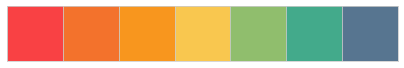

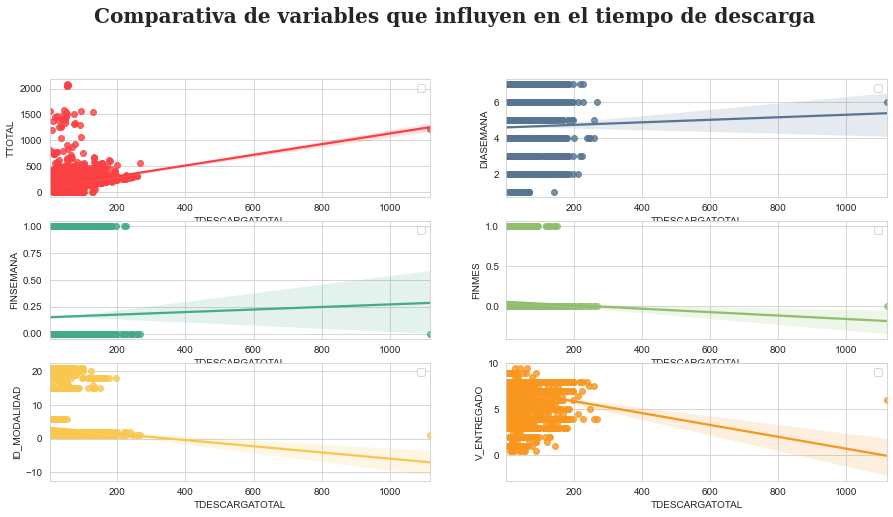

In [66]:
# SELECCIONAMOS LAS VARIABLES QUE PODRÍAN TENER INFLUENCIA EN EL TIEMPO DE DESCARGA Y LO ANALIZAMOS GRÁFICAMENTE
color=["#f94144","#f3722c","#f8961e","#f9c74f","#90be6d","#43aa8b","#577590"]
sns.palplot(color)
df2=dfclean[['V_ENTREGADO', 'TDESCARGATOTAL', 'TTOTAL', 'DIASEMANA','FINSEMANA', 'FINMES', 'ID_MODALIDAD']]
cols=df2.corr()['TDESCARGATOTAL'].sort_values(ascending=False)
fig=plt.figure(figsize=(15,10))
plt.suptitle("Comparativa de variables que influyen en el tiempo de descarga",family='Serif', weight='bold', size=20)
j=0
for i in cols.index[1:]:
    
    ax=plt.subplot(421+j)
    ax=sns.regplot(data=df2, x='TDESCARGATOTAL',y=i, color=color[-j])
    ax.legend('')
    j=j+1
    
plt.legend('')
     

In [ ]:
# hasta aca nos damos cuenta de que esta muy atomizado y no es facil ver una correlacion, procederemos a agrupar los datos para ver si es mas evidente



sns.distplot(dfclean['TTOTAL'])

f, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='TDESCARGATOTAL', y='dºistancia', hue='IDEOBRA', data=dfclean, ax=ax, )

ax = sns.swarmplot(x="DIASEMANA", y="TDESCARGATOTAL", data=dfclean)

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y='TDESCARGATOTAL', x='distancia', data=dfclean, orient="h", ax=ax)

import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')

raw_df = dfclean
data = raw_df.groupby('distancia')['TDESCARGATOTAL'].sum().reset_index()

data['TDESCARGATOTAL'].plot(kind='hist')

dfclean['TDESCARGATOTAL'].describe()
pd.qcut(dfclean['TDESCARGATOTAL'], q=30)


#Grafa para checar la linealidade entre las variables (distancia No Importa)
plt.scatter(dfclean['distancia'], dfclean['TDESCARGATOTAL'], color='red')
plt.title('Tiempo Descarga Vs Distancia', fontsize=14)
plt.xlabel('Distancia', fontsize=14)
plt.ylabel('Tiempo Descarga', fontsize=14)
plt.grid(True)
plt.show()

g =sns.scatterplot(x="distancia", y="TDESCARGATOTAL",
              hue="TTOTAL",
              data=dfclean);
g.set(xscale="log");

#Checando la linealidade entre 
plt.scatter(dfclean['FINSEMANA'], dfclean['TDESCARGATOTAL'], color='red')
plt.title('Tiempo Descarga Vs Fin Semana', fontsize=14)
plt.xlabel('FinSemana', fontsize=14)
plt.ylabel('TiempoDescarga', fontsize=14)
plt.grid(True)
plt.show()

plt.scatter(dfclean['WERKS'], dfclean['TDESCARGATOTAL'], color='red')
plt.title('Tiempo Descarga Vs Plantas', fontsize=14)
plt.xlabel('Plantas', fontsize=14)
plt.ylabel('Tiempo Descarga', fontsize=14)
plt.grid(True)
plt.show()

In [26]:
#Empezamos el Modelo
#1) Importar todas las libraria
#2) grafas de la linealidade entres las variables independentes y la variable dependent
#3) Criar analises de regression multipla para todas las variables  (Ire parar aqui)
#4) con data set maior tener un modelo de entrenamento
#5)Analisas resultadoss